In [1]:
import os
import pickle
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest, probplot, kstest
from statsmodels.tsa.stattools import kpss, adfuller

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L1L2

In [2]:
MODEL = "convolutional"

config = {    
    "EMBEDDING_SIZE": 16,
    "DENSE_SIZE": 16, 
    "DROPOUT": 0.2,
    
    "LR": 0.001,
    "BATCH_SIZE": 32,
    "EPOCHS": 30,
}

In [3]:
RUN_WANDB = False

if(RUN_WANDB):
    import wandb
    from wandb.keras import WandbCallback
    from secrets import WANDB
    wandb.login(key=WANDB)

## **Load Data Function**

In [4]:
def get_data(fold):
    df = pd.read_csv(f'./data/fold_{fold}.csv')
    with open(f'./data/fold_{fold}.npy', mode='rb') as f:
        train_historical_series = np.load(f, allow_pickle=False)
        train_historical_covariates = np.load(f, allow_pickle=False) 
        train_future_covariates = np.load(f, allow_pickle=False)
        train_future_series = np.load(f, allow_pickle=False)
        # val arrays
        val_historical_series = np.load(f, allow_pickle=False)
        val_historical_covariates = np.load(f, allow_pickle=False) 
        val_future_covariates = np.load(f, allow_pickle=False)
        val_future_series = np.load(f, allow_pickle=False)
        # test arrays
        test_historical_series = np.load(f, allow_pickle=False)
        test_historical_covariates = np.load(f, allow_pickle=False) 
        test_future_covariates = np.load(f, allow_pickle=False)
        test_future_series = np.load(f, allow_pickle=False)
        # forecast arrays
        forecast_historical_series = np.load(f, allow_pickle=False)
        forecast_historical_covariates = np.load(f, allow_pickle=False) 
        forecast_future_covariates = np.load(f, allow_pickle=False)
        forecast_future_series = np.load(f, allow_pickle=False)
        forecast_dates = np.load(f, allow_pickle=True)
        forecast_historical_dates = np.load(f, allow_pickle=True)
        # data info
        data_features = np.load(f, allow_pickle=False)
    return (
        (train_historical_series,train_historical_covariates,train_future_covariates),
        train_future_series, 
        (val_historical_series,val_historical_covariates,val_future_covariates),
        val_future_series, 
        (test_historical_series,test_historical_covariates,test_future_covariates), 
        test_future_series,
        (forecast_historical_series,forecast_historical_covariates,forecast_future_covariates), 
        forecast_future_series,
        forecast_dates,
        forecast_historical_dates,
        data_features,
        df
    )

X_train, y_train, X_val, y_val, X_test, y_test, X_forecast, y_forecast, forecast_dates, forecast_historical_dates, data_features, df = get_data(2)
print(data_features)
df

[30.73084645 29.04061676]


,datetime,level
0,2005-12-31 12:00:00,60.0
1,2005-12-31 13:00:00,43.0
2,2005-12-31 14:00:00,23.0
3,2005-12-31 15:00:00,1.0
4,2005-12-31 16:00:00,-12.0
...,...,...
52591,2011-12-31 19:00:00,0.0
52592,2011-12-31 20:00:00,-2.0
52593,2011-12-31 21:00:00,2.0
52594,2011-12-31 22:00:00,9.0


In [5]:
X_train[0].shape, X_train[1].shape, X_train[2].shape, y_train.shape

((43734, 72, 1), (43734, 72, 4), (43734, 1, 4), (43734, 1))

## **Model Functions**

In [6]:
def simple_encoder_decoder(historical_series_shape, historical_covariates_shape, future_covariates_shape):
    historical_series = tf.keras.layers.Input(shape=historical_series_shape)
    historical_covariates = tf.keras.layers.Input(shape=historical_covariates_shape)
    future_covariates = tf.keras.layers.Input(shape=future_covariates_shape)
    
    historicals = tf.keras.layers.Concatenate()([historical_series, historical_covariates])
    encoder = tf.keras.layers.Conv1D(config["EMBEDDING_SIZE"],
                                     kernel_size=16,
                                     strides=2,
                                     padding='valid')(historicals)
    encoder = tf.keras.layers.Conv1D(config["EMBEDDING_SIZE"],
                                     kernel_size=8,
                                     strides=2,
                                     padding='valid')(encoder)
    encoder = tf.keras.layers.Conv1D(config["EMBEDDING_SIZE"],
                                     kernel_size=4,
                                     strides=2,
                                     padding='valid')(encoder)
    encoder = tf.keras.layers.Flatten()(encoder)
    
    encoder = tf.expand_dims(encoder, 1)
    encoded_inputs = tf.keras.layers.Concatenate()([future_covariates, encoder])
    encoded_inputs = tf.squeeze(encoded_inputs, axis=1)
    encoded_inputs = tf.keras.layers.Dropout(config["DROPOUT"])(encoded_inputs)
    
    decoder = tf.keras.layers.Dense(config["DENSE_SIZE"])(encoded_inputs)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation('relu')(decoder)
    outputs = tf.keras.layers.Dense(1)(decoder)
    
    model = tf.keras.models.Model(inputs=[historical_series, historical_covariates, future_covariates], outputs=outputs)
    model.compile(loss="mse", metrics=["mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["LR"]))
    return model

model = simple_encoder_decoder(X_train[0].shape[1:], X_train[1].shape[1:], X_train[2].shape[1:])
model.summary()

Metal device set to: Apple M1 Pro
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 72, 4)]      0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 72, 5)        0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 29, 16)       1296   

2022-12-16 12:40:37.246190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-16 12:40:37.246300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
reducer = tf.keras.callbacks.ReduceLROnPlateau(monior='val_loss', factor=0.1, patience=2, mode='min', cooldown=1)
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min', restore_best_weights=True)
if(RUN_WANDB):
    callbacks = [reducer, stopper, WandbCallback()]
else:
    callbacks = [reducer, stopper]

model.fit(X_train, y_train,
          batch_size=config["BATCH_SIZE"],
          epochs=config["EPOCHS"], 
          callbacks=callbacks,
          validation_data=(X_val, y_val),
          validation_batch_size=config["BATCH_SIZE"],
          shuffle=True)

Epoch 1/30


2022-12-16 12:40:37.516500: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-16 12:40:37.934499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1367/1367 [==============================] - ETA: 0s - loss: 0.1840 - mae: 0.3276

2022-12-16 12:40:54.059250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1367/1367 [==============================] - 18s 13ms/step - loss: 0.1840 - mae: 0.3276 - val_loss: 0.0646 - val_mae: 0.1897 - lr: 0.0010
Epoch 2/30
1367/1367 [==============================] - 17s 12ms/step - loss: 0.1356 - mae: 0.2805 - val_loss: 0.0609 - val_mae: 0.1812 - lr: 0.0010
Epoch 3/30
1367/1367 [==============================] - 17s 12ms/step - loss: 0.1299 - mae: 0.2747 - val_loss: 0.0573 - val_mae: 0.1762 - lr: 0.0010
Epoch 4/30
1367/1367 [==============================] - 17s 12ms/step - loss: 0.1275 - mae: 0.2719 - val_loss: 0.0541 - val_mae: 0.1717 - lr: 0.0010
Epoch 5/30
1367/1367 [==============================] - 17s 12ms/step - loss: 0.1233 - mae: 0.2672 - val_loss: 0.0596 - val_mae: 0.1840 - lr: 0.0010
Epoch 6/30
1367/1367 [==============================] - 17s 12ms/step - loss: 0.1242 - mae: 0.2689 - val_loss: 0.0553 - val_mae: 0.1746 - lr: 0.0010
Epoch 7/30
1367/1367 [==============================] - 16s 12ms/step - loss: 0.1138 - mae: 0.2562 - val_loss: 0.0512

In [8]:
model.evaluate(X_test, y_test)

271/271 [==============================] - 2s 6ms/step - loss: 0.0829 - mae: 0.1967


[0.08289039134979248, 0.19668594002723694]

## **Single Step Prediction Analysis**

In [9]:
single_step_predictions = model.predict(X_test)
real_single_step_predictions = (single_step_predictions * data_features[1]) + data_features[0]
single_step_actuals = (y_test * data_features[1]) + data_features[0]

 34/271 [==>...........................] - ETA: 0s

2022-12-16 12:44:16.630043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 1s 3ms/step


### **Single Step Prediction Error Metrics**

In [10]:
def r_squared(predictions, actuals):
    sum_squared_regression = np.sum(np.square(actuals - predictions))
    total_sum_of_squares = np.sum(np.square(actuals - np.mean(actuals)))
    return 1 - (sum_squared_regression / total_sum_of_squares)

single_step_error = real_single_step_predictions - single_step_actuals
single_step_error = single_step_error.flatten()
single_step_rmse = np.sqrt(np.mean(np.square(real_single_step_predictions - single_step_actuals)))
single_step_mse = np.mean(np.square(real_single_step_predictions - single_step_actuals))
single_step_mae = np.mean(np.abs(real_single_step_predictions - single_step_actuals))
single_step_r2 = r_squared(real_single_step_predictions, single_step_actuals)
print(f"Single Step RMSE: {single_step_rmse:.4f}")
print(f"Single Step MSE:  {single_step_mse:.4f}")
print(f"Single Step MAE:  {single_step_mae:.4f}")
print(f"Single Step r2:   {single_step_r2*100:.4f}%")

Single Step RMSE: 8.3610
Single Step MSE:  69.9062
Single Step MAE:  5.7119
Single Step r2:   91.7223%


### **Single Step Prediction Forecasted VS Actuals**

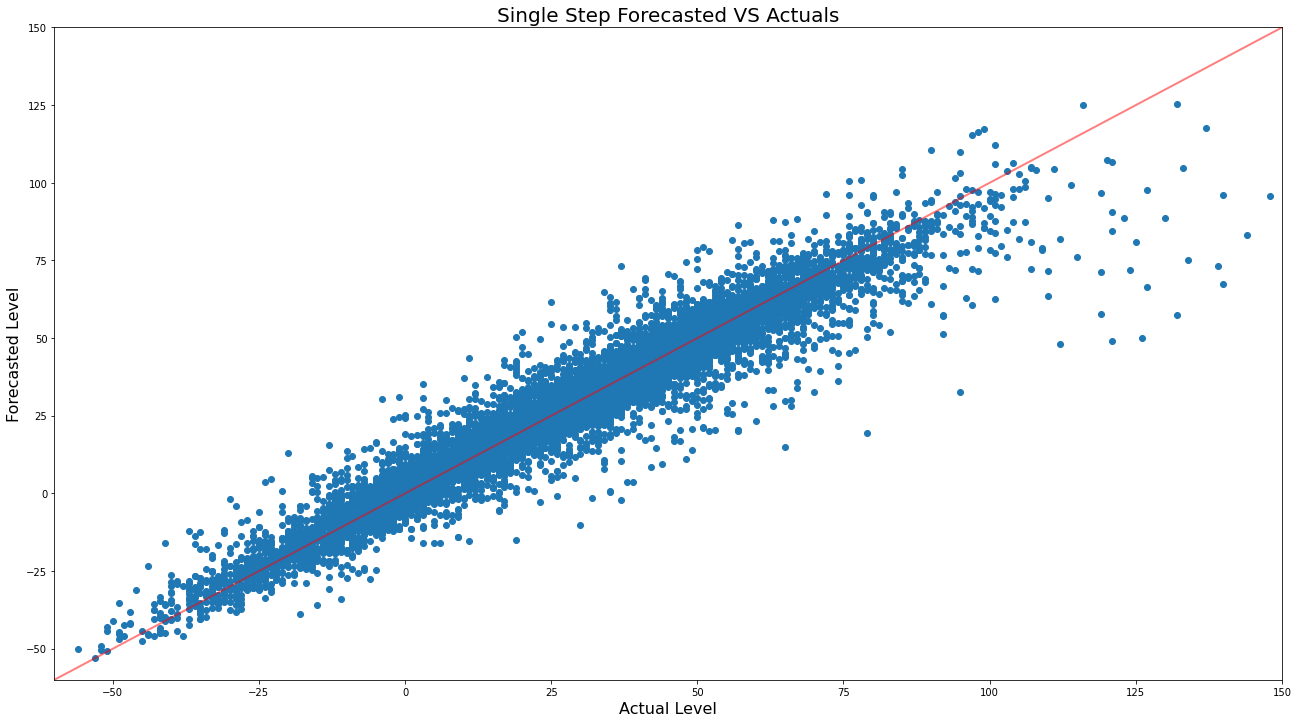

In [11]:
_, ax = plt.subplots(1,1,figsize=(22,12))
ax.set_title("Single Step Forecasted VS Actuals", size=20)
ax.set_xlabel("Actual Level", size=16)
ax.set_ylabel("Forecasted Level", size=16)
ax.scatter(single_step_actuals, real_single_step_predictions)

min_ = np.min([np.min(single_step_actuals), np.min(real_single_step_predictions)]) - 4
max_ = np.max([np.max(single_step_actuals), np.max(real_single_step_predictions)]) + 2
ax.set_xlim([min_,max_])
ax.set_ylim([min_,max_])
ax.plot([min_,max_], [min_,max_], 'red', linewidth=2, alpha=0.5);
plt.show()

### **Analyze the Residuals Over Time**

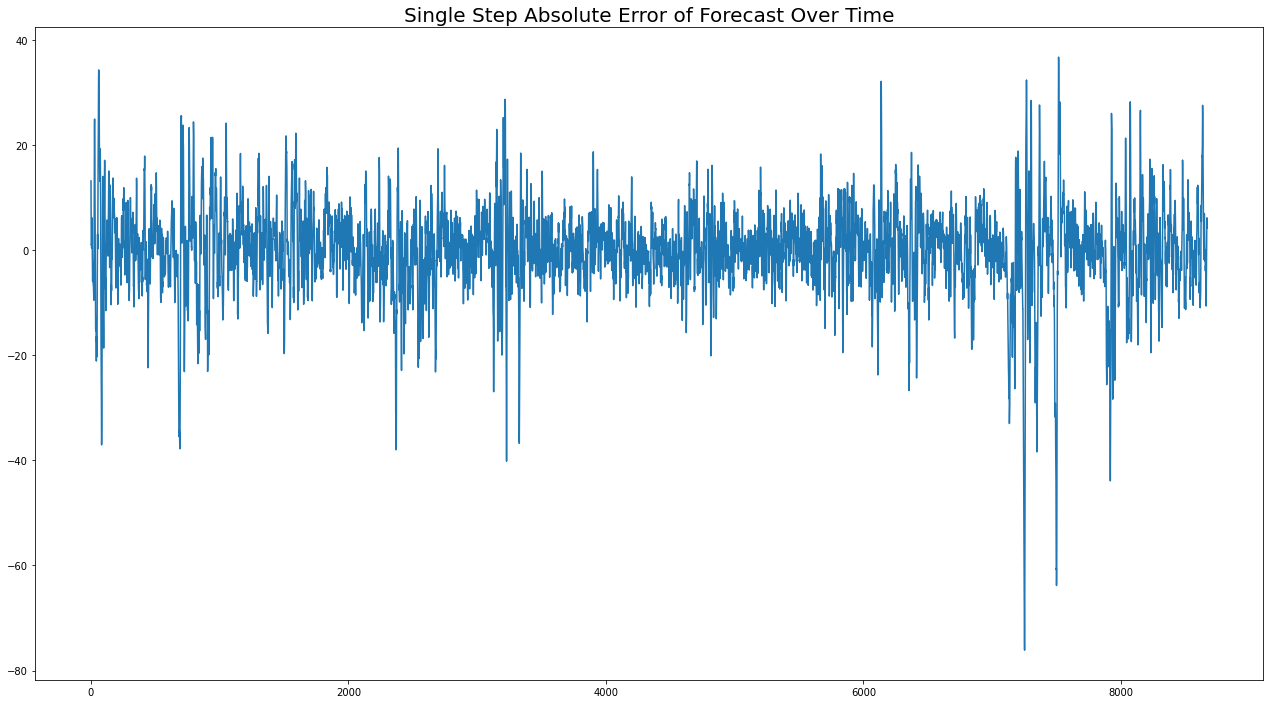

In [12]:
_, ax = plt.subplots(1,1,figsize=(22,12))
ax.set_title("Single Step Absolute Error of Forecast Over Time", size=20)
# ax.set_xlabel("Time Steps From Start of Test Portion", size=16)
# ax.set_ylabel("Absolute Error", size=16)
ax.plot(np.arange(len(single_step_error)), single_step_error);

In [13]:
# null is the presence of a unit root

dftest = adfuller(single_step_error, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.437136e+01
p-value                        9.482168e-27
#Lags Used                     3.700000e+01
Number of Observations Used    8.632000e+03
Critical Value (1%)           -3.431108e+00
Critical Value (5%)           -2.861875e+00
Critical Value (10%)          -2.566948e+00
dtype: float64

In [14]:
# null is stationary

kpsstest = kpss(single_step_error, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
kpss_output

Test Statistic            0.438519
p-value                   0.060552
#Lags Used               45.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

### **Test the Normality of Residuals**

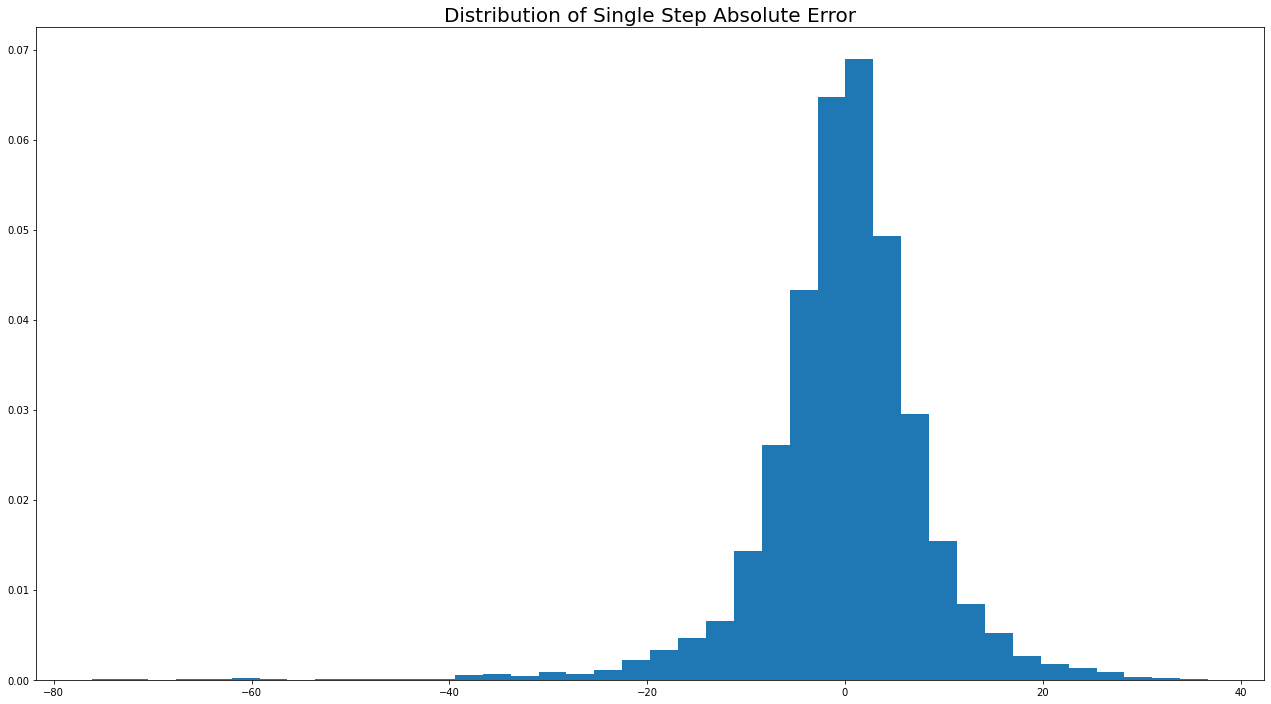

In [15]:
_, ax = plt.subplots(1,1,figsize=(22,12))
ax.set_title("Distribution of Single Step Absolute Error", size=20)
# ax.set_xlabel("Absolute Error", size=16)
# ax.set_ylabel("Density", size=16)
ax.hist(single_step_error, bins=40, density=True);

In [16]:
mean, sigma = single_step_error.mean(), single_step_error.std()
mean, sigma

(-0.025832300285154562, 8.360954072479986)

### **Test Normal Distribution**

In [17]:
kstest(single_step_error, stats.norm.cdf, args=(mean,sigma), N=len(single_step_error))

KstestResult(statistic=0.08051873541381435, pvalue=2.426730678171339e-49)

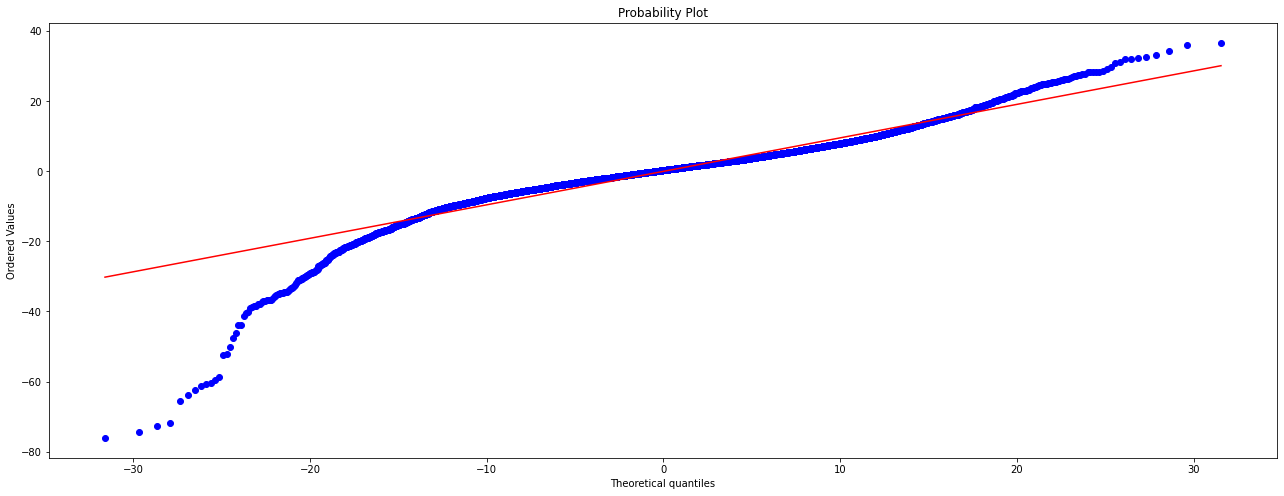

In [18]:
_, ax = plt.subplots(1,1,figsize=(22,8))
probplot(single_step_error, dist=stats.norm, sparams=(mean,sigma), plot=ax);

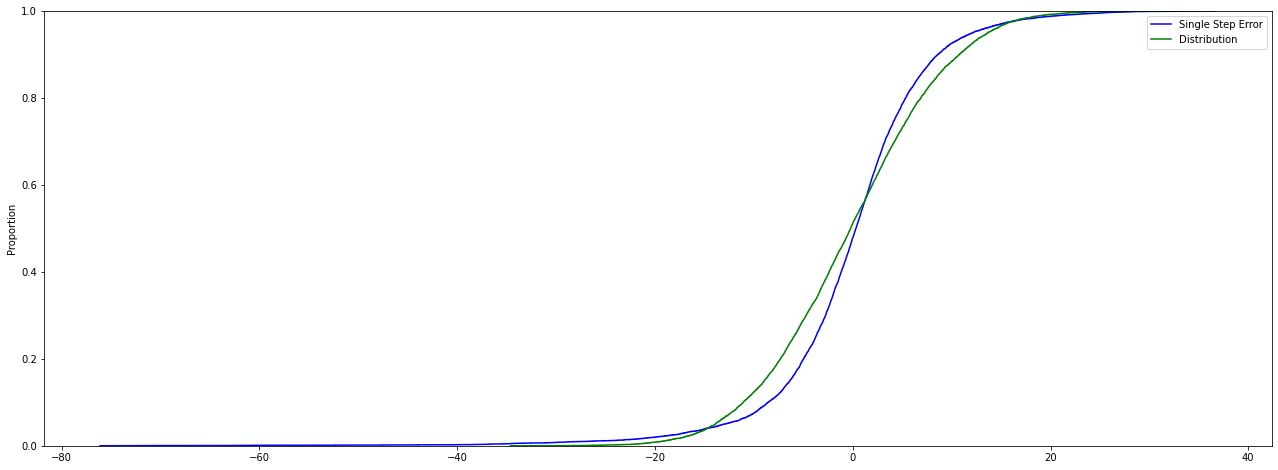

In [19]:
data_norm = np.random.normal(mean, sigma, len(single_step_error))
_, ax = plt.subplots(1,1,figsize=(22,8))
sns.ecdfplot(single_step_error, c='blue', ax=ax, label='Single Step Error')
sns.ecdfplot(data_norm, c='green', ax=ax, label='Distribution')
ax.legend(loc='best');

### **Student T Distribution**

In [20]:
kstest(single_step_error, stats.t.cdf, args=(5,mean,sigma), N=len(single_step_error))

KstestResult(statistic=0.0939626888087455, pvalue=4.531476863097438e-67)

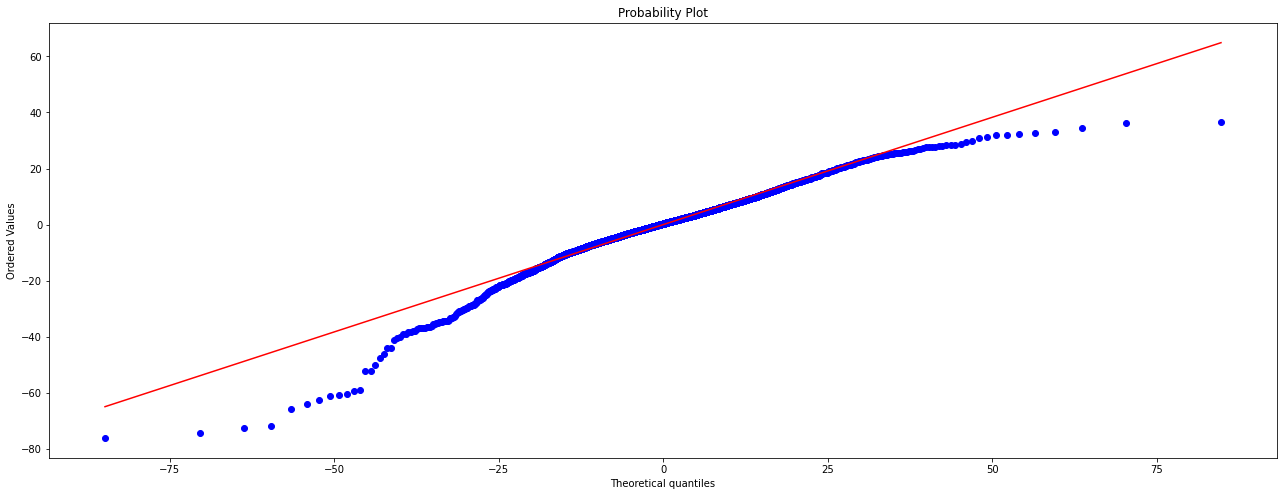

In [21]:
_, ax = plt.subplots(1,1,figsize=(22,8))
probplot(single_step_error, dist=stats.t, sparams=(5,single_step_error.mean(),single_step_error.std()), plot=ax);

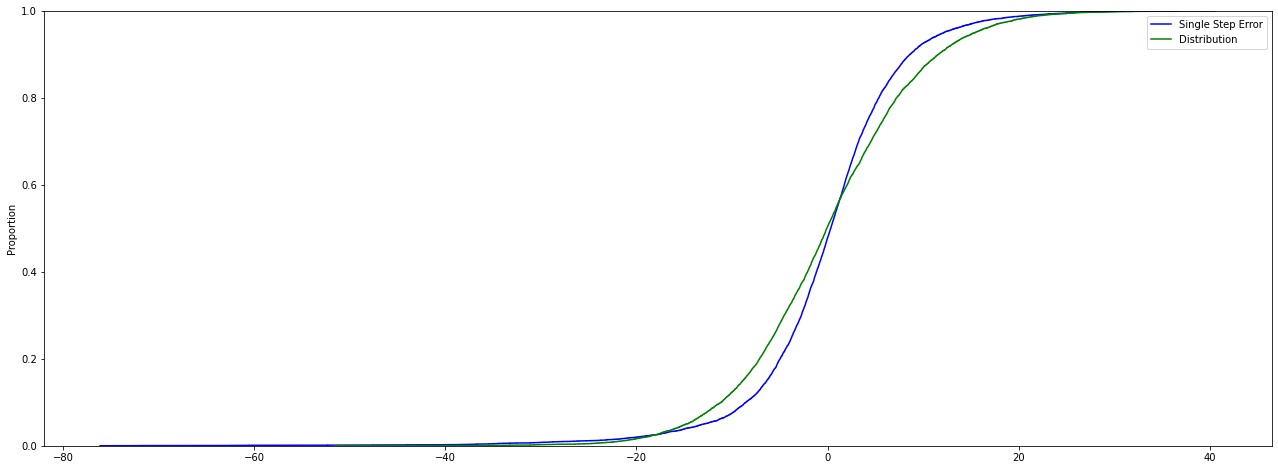

In [22]:
data_norm = stats.t.rvs(12, mean, sigma, size=len(single_step_error))
_, ax = plt.subplots(1,1,figsize=(22,8))
sns.ecdfplot(single_step_error, c='blue', ax=ax, label='Single Step Error')
sns.ecdfplot(data_norm, c='green', ax=ax, label='Distribution')
ax.legend(loc='best');

# Multi-Step Predictions

In [23]:
forecast_length = y_forecast.shape[1]
forecast_historical_series,forecast_historical_covariates,forecast_future_covariates=np.copy(X_forecast[0]),np.copy(X_forecast[1]),np.copy(X_forecast[2])
forecasts = []
for step in range(forecast_length):
    future_covaraites = forecast_future_covariates[:, step:step+1, :]
    predictions = model.predict((forecast_historical_series,forecast_historical_covariates,future_covaraites))
    forecasts.append(predictions)
    # series
    forecast_historical_series = forecast_historical_series[:,1:,:]
    forecast_historical_series = np.squeeze(forecast_historical_series, axis=-1)
    forecast_historical_series = np.concatenate([forecast_historical_series,predictions], axis=-1)
    forecast_historical_series = np.expand_dims(forecast_historical_series, -1)
    # covariates
    forecast_historical_covariates = forecast_historical_covariates[:,1:,:]
    forecast_historical_covariates = np.concatenate([forecast_historical_covariates,future_covaraites], axis=-2)

forecasts = np.stack(forecasts, axis=1)
forecasts = np.squeeze(forecasts, axis=-1)
forecasts.shape, forecast_dates.shape

271/271 [==============================] - 1s 3ms/step


((8670, 24), (8670, 24))

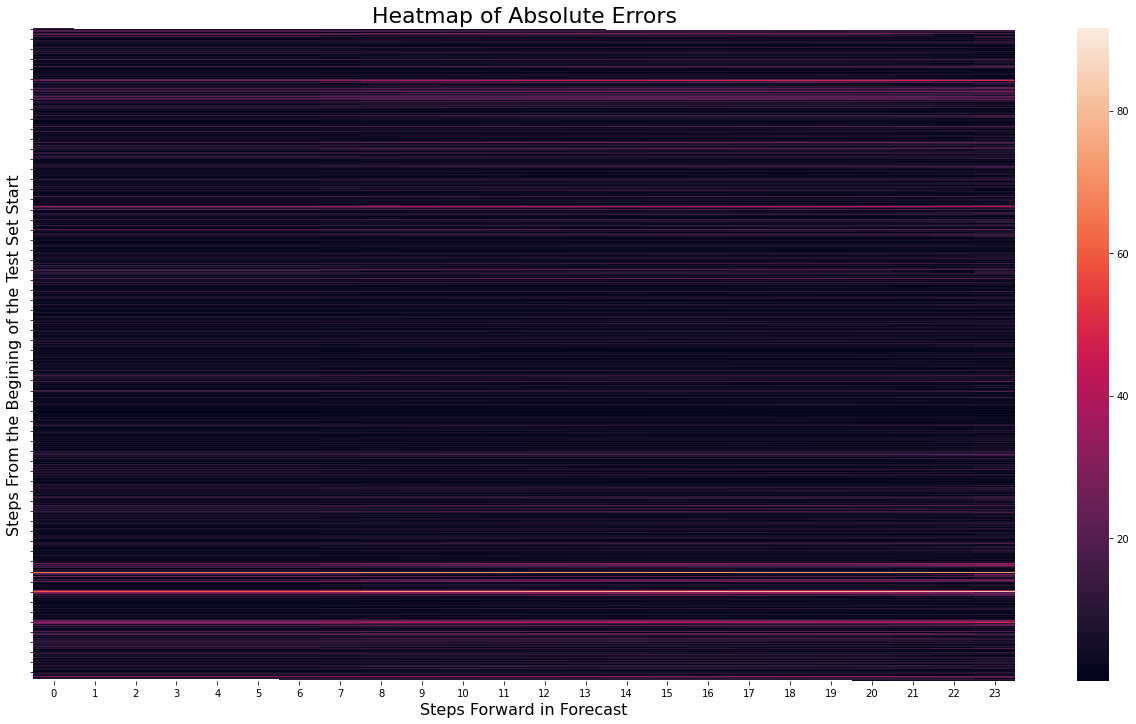

In [24]:
real_forecasts = (forecasts * data_features[1]) + data_features[0]
actuals = (y_forecast * data_features[1]) + data_features[0]
errors = np.abs(real_forecasts - actuals)

matrix_dates = []
error_matrix = np.full((forecast_dates.shape[0]+forecast_dates.shape[1]-1,forecast_dates.shape[1]), np.nan)
for idx in range(forecast_dates.shape[0]):
    matrix_dates.append(forecast_dates[idx,0])
    for step_idx in range(forecast_dates.shape[1]):
        error_matrix[idx+step_idx, step_idx] = errors[idx,step_idx]
        if(idx == forecast_dates.shape[0]-1 and step_idx > 0):
            matrix_dates.append(forecast_dates[idx, step_idx])

_, ax = plt.subplots(1,1,figsize=(22,12))
sns.heatmap(error_matrix)
ax.set_title('Heatmap of Absolute Errors', size=22)
ax.set_ylabel('Steps From the Begining of the Test Set Start', size=16)
ax.set_xlabel('Steps Forward in Forecast', size=16)
ax.set_yticklabels([]);

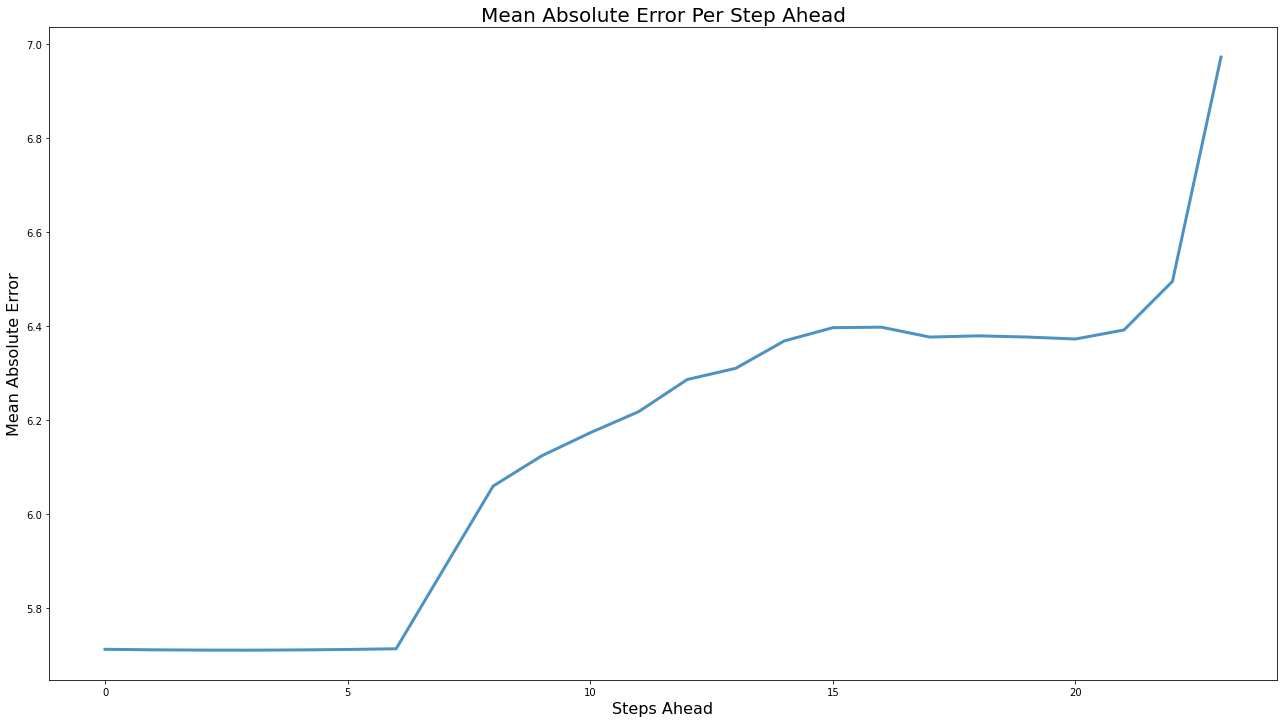

In [25]:
step_errors = np.nanmean(error_matrix, axis=0)
_, ax = plt.subplots(1,1,figsize=(22,12))
ax.set_title('Mean Absolute Error Per Step Ahead', size=20)
ax.set_xlabel('Steps Ahead', size=16)
ax.set_ylabel('Mean Absolute Error', size=16)
ax.plot(np.arange(len(step_errors)), step_errors, linewidth=3, alpha=0.8);

## **Display Forecasts at a Number of Points**

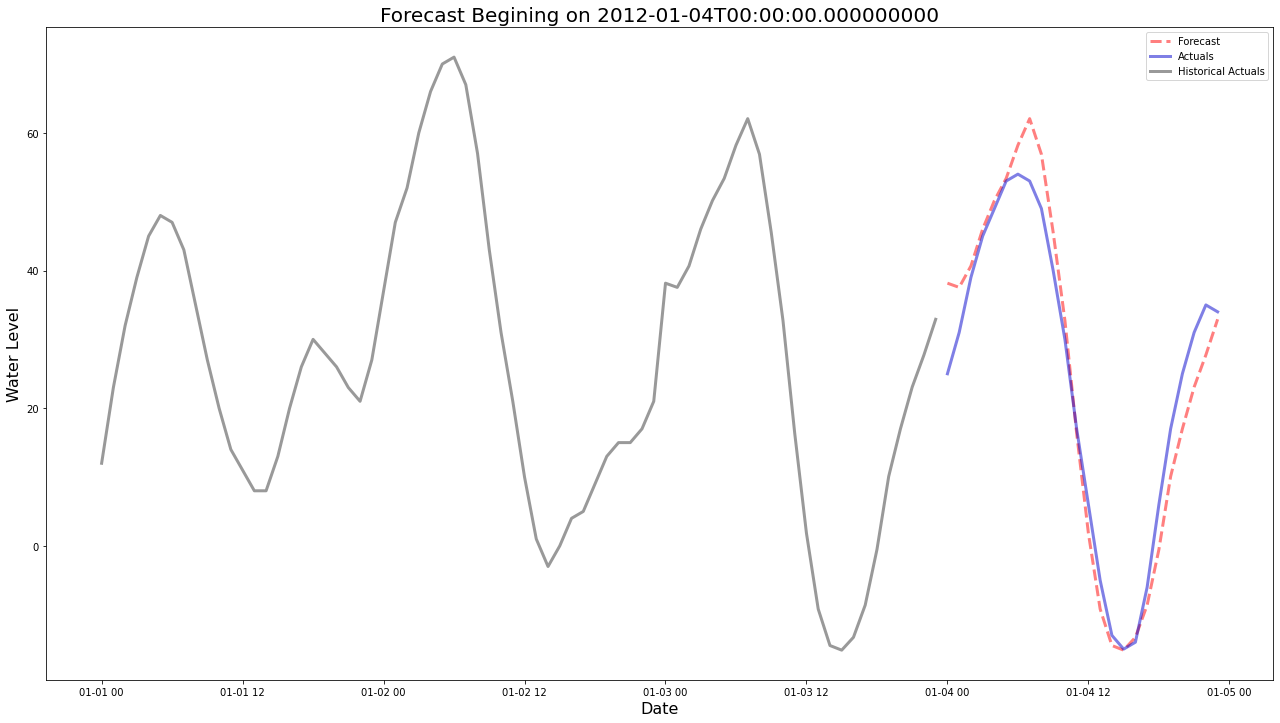

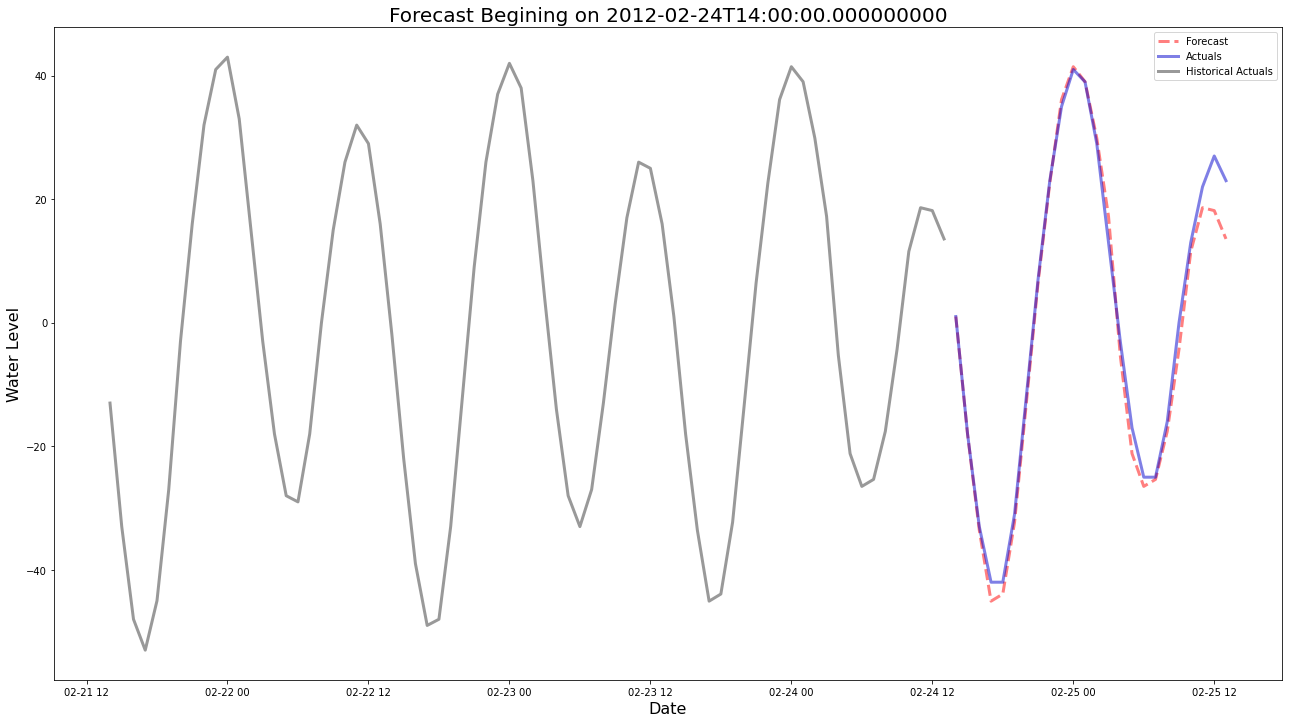

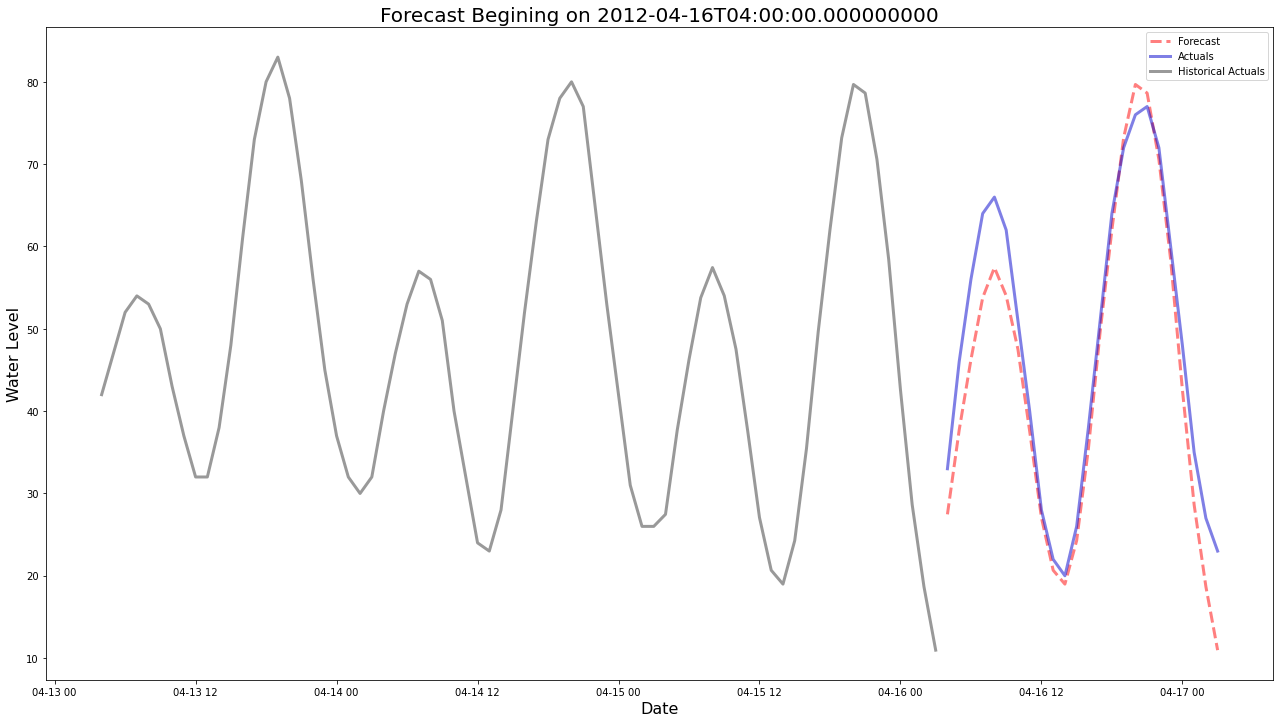

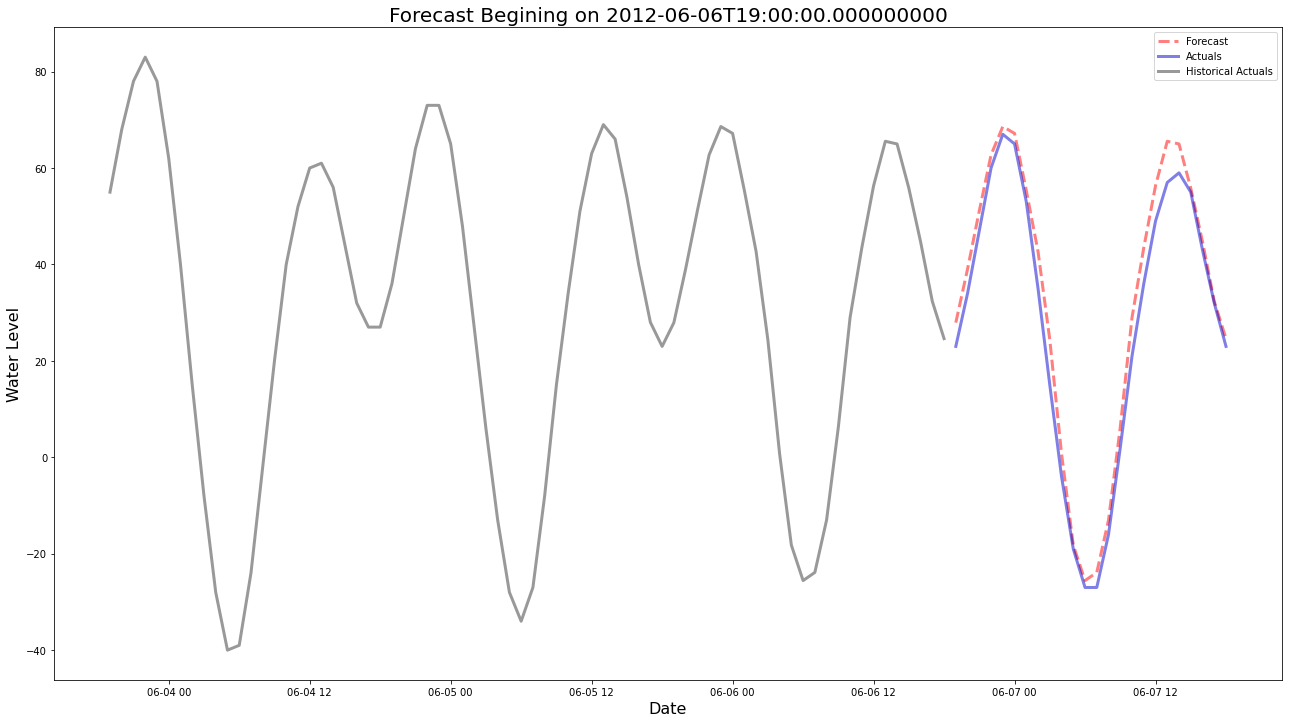

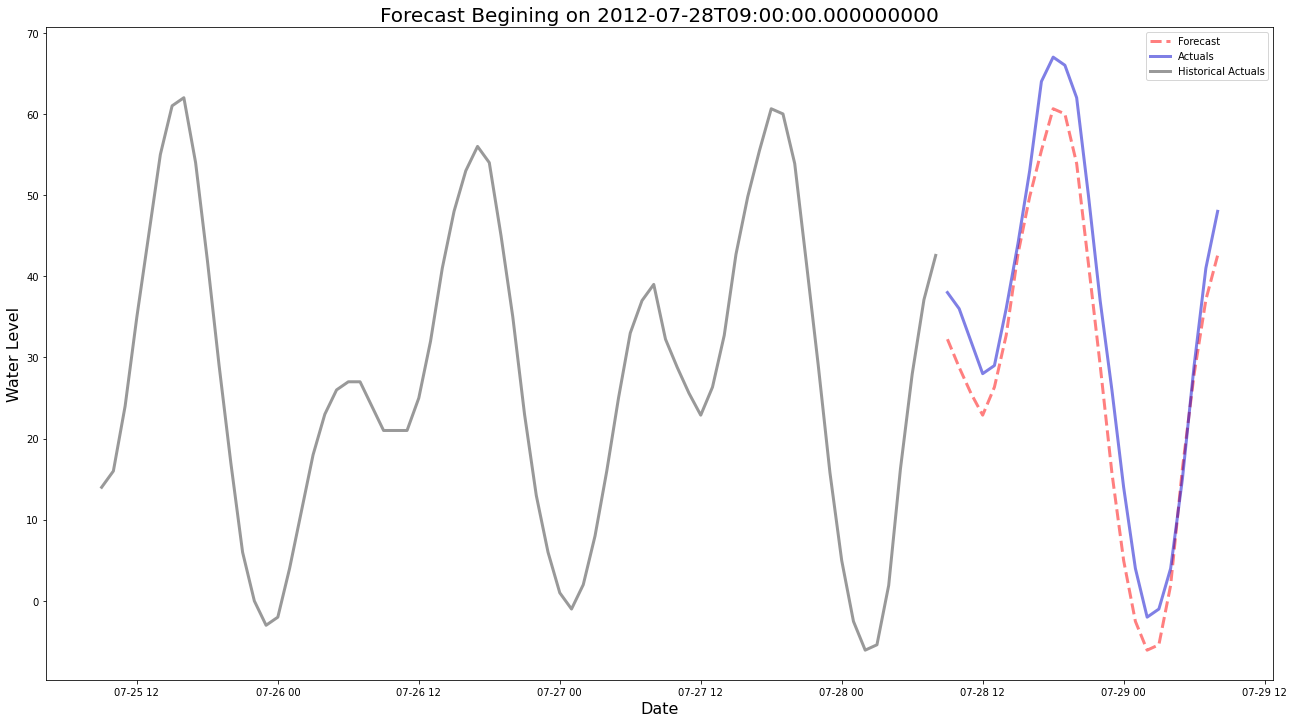

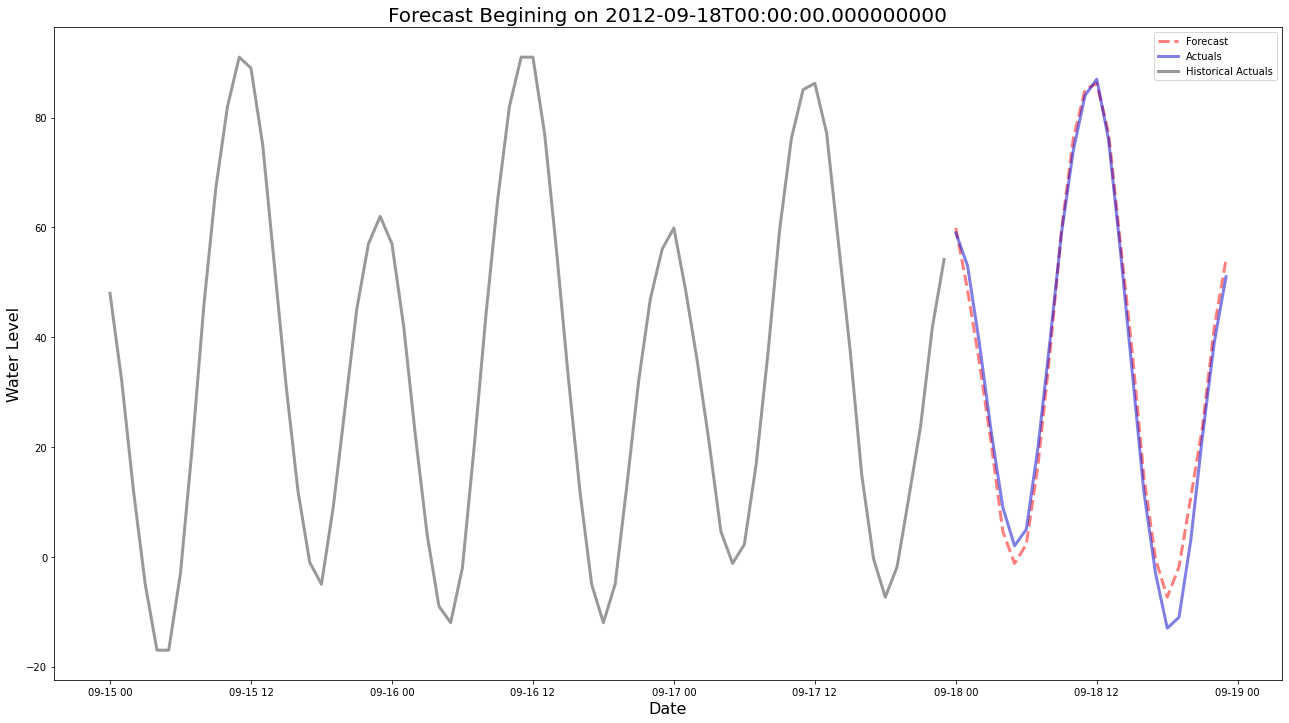

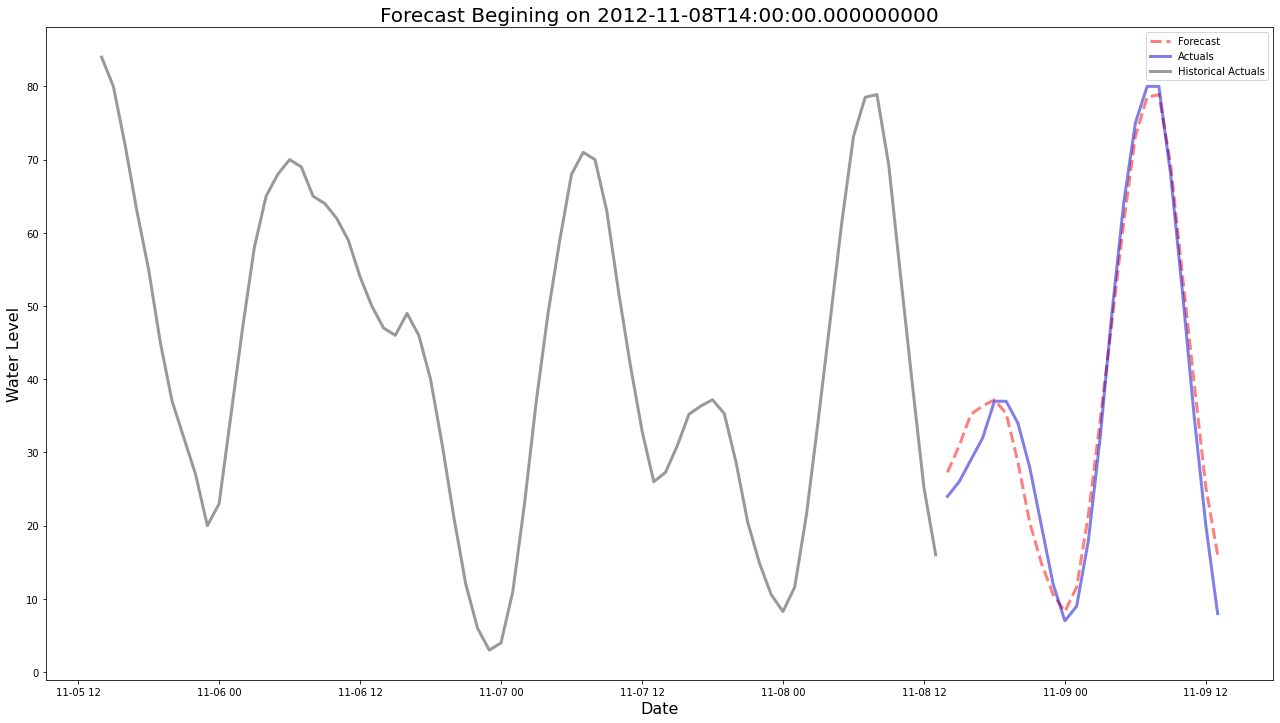

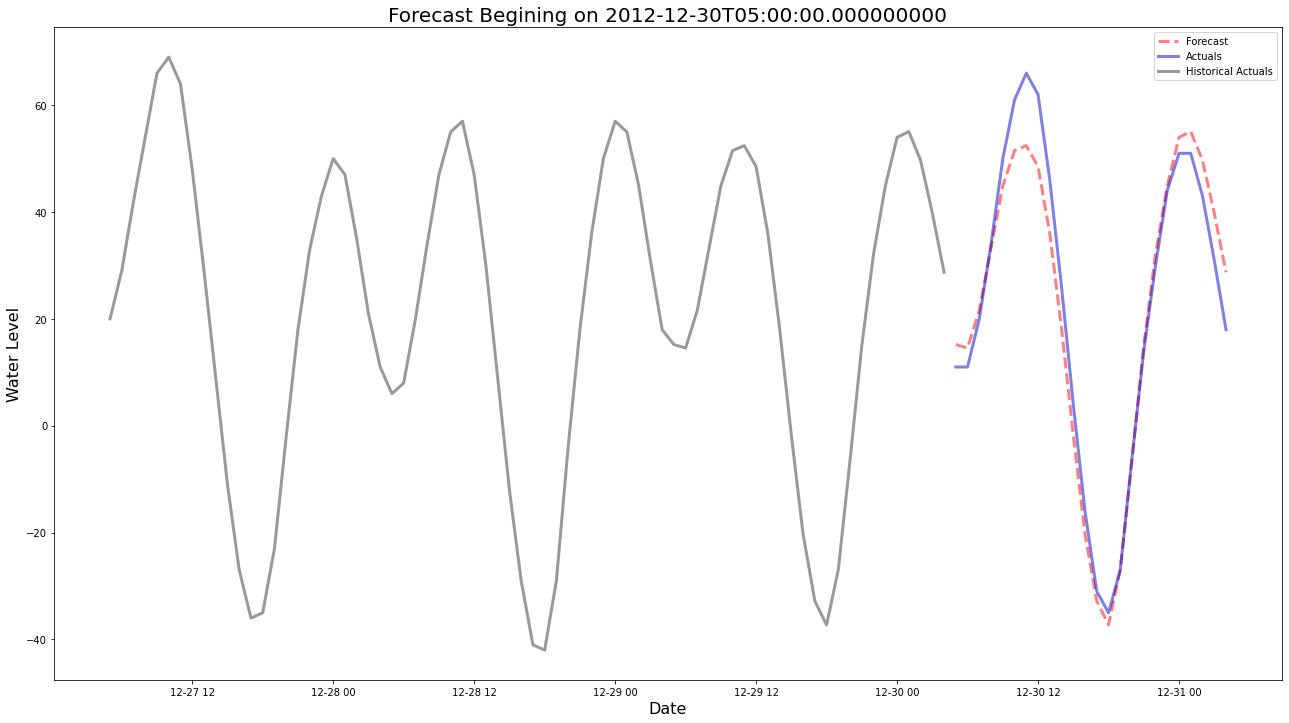

In [26]:
sample_points = np.linspace(start=0, stop=forecasts.shape[0]-1, num=8).astype(int)
for sample_point in sample_points:
    _, ax = plt.subplots(1,1,figsize=(22,12))
    ax.set_title(f"Forecast Begining on {forecast_dates[sample_point,0]}", fontdict={'size':20})
    ax.set_ylabel("Water Level", fontdict={'size':16})
    ax.set_xlabel("Date", fontdict={'size':16})
    ax.plot(forecast_dates[sample_point,:], real_forecasts[sample_point,:], 'red', label='Forecast', alpha=0.5, linewidth=3, linestyle='dashed')
    ax.plot(forecast_dates[sample_point,:], actuals[sample_point,:], 'mediumblue', label='Actuals', alpha=0.5, linewidth=3)
    # get the actuals
    historical_actuals = (forecast_historical_series[sample_point,:] * data_features[1]) + data_features[0]
    ax.plot(forecast_historical_dates[sample_point,:], historical_actuals, 'grey', label='Historical Actuals', alpha=0.8, linewidth=3)
    ax.legend(loc='best')
    plt.show()